In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times

# Generate simulated data  

Let's download data on new severe hospitalized during the 4th wave

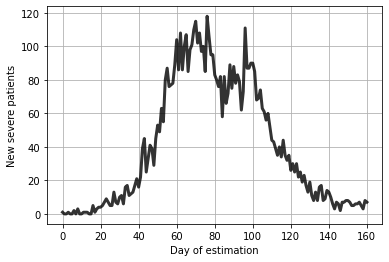

In [16]:
moh_df = pd.read_excel('moh_data.xlsx', skiprows=1, parse_dates=['תאריך'])
moh_df.columns = ['date', 'new_severe']
new_hosped = moh_df.iloc[140:301]['new_severe'].values
times = np.arange(len(new_hosped))

fig, ax = plt.subplots()
ax.plot(times, new_hosped, color='k', lw=3, alpha=0.8, label='New severe patients')
ax.set_ylabel('New severe patients')
ax.set_xlabel('Day of estimation')
ax.grid()


For Length of Stay (LOS) lets simulate from a fake distribution, somewhat resembling the literature  

7.072982297860133


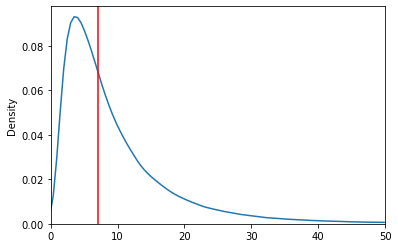

In [17]:
N = 1_000_000
START_DAY = 14 # day at which tomstart calculating LOS

# distribution simulated paramateres
ln_mean=10
ln_std=10


def log_normal_int_dist(ln_mean, ln_std, size, round=False, max_val=30):
    mean = np.log(
        ln_mean ** 2 / np.sqrt(ln_std ** 2 + ln_mean ** 2)
    )  # Computes the mean of the underlying normal distribution
    sigma = np.sqrt(
        np.log(ln_std ** 2 / ln_mean ** 2 + 1)
    )  # Computes sigma for the underlying normal distribution
    samples = np.random.lognormal(mean=mean, sigma=sigma, size=size)
    samples = np.clip(samples, a_min=0, a_max=max_val)
    if round:
        # round to integer
        samples = np.round(samples)
    return samples

los = log_normal_int_dist(ln_mean=ln_mean, ln_std=ln_std, size=N, round=False, max_val=100)

fig, ax = plt.subplots(1,1)
sns.kdeplot(los, ax=ax)
ax.axvline(np.median(los), color='r')
ax.set_xlim(0,50)
true_median = np.median(los)
print(true_median)


True (generating process) median LOS is ~ 7.07

Now let's generate a data table

In [18]:
los = []
t_adm = []
t_release = []

for t, num_new_hosped in enumerate(new_hosped):
    tmp_t_adm = np.full(num_new_hosped, t)
    t_adm.extend(tmp_t_adm)
    tmp_los = log_normal_int_dist(ln_mean=ln_mean, ln_std=ln_std, size=num_new_hosped, round=False, max_val=50)
    los.extend(tmp_los)
    
data = pd.DataFrame({'t_adm': t_adm, 'los': los})
data['t_release'] = data['t_adm'] + data['los']

data.head()

,t_adm,los,t_release
0,0,3.364114,3.364114
1,3,22.274032,25.274032
2,6,34.624566,40.624566
3,6,3.091598,9.091598
4,8,4.295710,12.295710


Now we have data, let's try a few methods to estimate median LOS  

# Kaplan-Meier

To do this, we need to transform data to the correct format for survival analysis (duration and event column, taking censoring into account)  
We run a sliding window whose right edge is the "current time", so all information that happened before that time is available to us

In [19]:
km_median_los_7day = np.zeros_like(times, dtype=float)

for current_t in times[START_DAY:]:
    # filter only ids that have admission before current_t
    df = data[data["t_adm"]<=current_t].copy()

    # prep survival columns for Uncensored individuals
    idx_uncensored = df['t_release']<=current_t
    df.loc[idx_uncensored, 'T'] = df.loc[idx_uncensored, 'los']
    df.loc[idx_uncensored, 'E'] = 1

    # prep survival columns for Censored individuals
    idx_censored = df['t_release']>current_t
    df.loc[idx_censored, 'T'] = (current_t - df.loc[idx_censored, 't_adm'])
    df.loc[idx_censored, 'E'] = 0

    # Fit KM
    kmf = KaplanMeierFitter()
    kmf.fit(df['T'], df['E'])
    km_median_los_7day[current_t] = kmf.median_survival_time_
    median_ci = median_survival_times(kmf.confidence_interval_)

# Naive estimation  

Example when estimating based on all available data on released patients up to current time, not taking censoring into account.

In [20]:
naive_median_los_7day = np.zeros_like(times, dtype=float)

for current_t in times[START_DAY:]: # start one week after start of data
    # filter only ids that have admission before current_t
    df = data[data["t_adm"]<=current_t].copy()
    # now choose only released patients (naively)
    df = df[df["t_release"]<=current_t]
    # calc los
    naive_median_los_7day[current_t] = df['los'].median()

# Methods comparison - estimation of median LOS

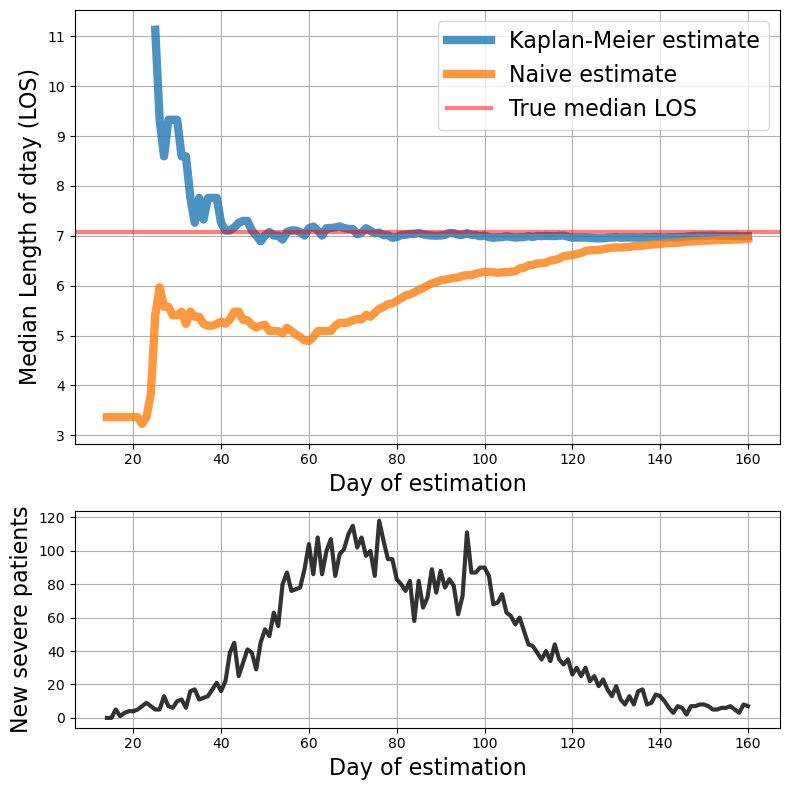

In [21]:
fig , axes = plt.subplots(2,1, figsize=(8,8), dpi=100, gridspec_kw={'height_ratios': [2, 1]})
sz = 16

ax = axes[0]
ax.plot(times[START_DAY:],km_median_los_7day[START_DAY:], label='Kaplan-Meier estimate', lw=6, alpha=0.8)
ax.plot(times[START_DAY:],naive_median_los_7day[START_DAY:], label='Naive estimate', lw=6, alpha=0.8)
ax.axhline(true_median,label='True median LOS', color='r', ls='-', lw=3, alpha=0.5)
ax.set_ylabel('Median Length of dtay (LOS)', fontsize=sz)
ax.set_xlabel('Day of estimation', fontsize=sz)
ax.legend(fontsize=sz)
ax.grid()

ax = axes[1]
ax.plot(times[START_DAY:], new_hosped[START_DAY:], color='k', lw=3, alpha=0.8, label='New severe patients')
ax.set_ylabel('New severe patients', fontsize=sz)
ax.set_xlabel('Day of estimation', fontsize=sz)
ax.grid()

fig.tight_layout()
fig.savefig('median_LOS_summary.png', dpi=100)

So we can clearly see that the naive estimate is biased and estimates shorter LOS, only stabilizeing at the end of the wave.  
While the KM estimator stabilizes wuickly after a few days to the true LOS. 
Estimating LOS needs to take right censoring into account.